# 머신러닝 실습
## 보험료 예측
---

In [51]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

In [2]:
# 구글 드라이브 마운트가 필요할 시 주석 해제
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 데이터 불러오기
data = pd.read_csv("/content/drive/MyDrive/머신러닝/3/ch3_premium.csv")

In [4]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
df = data.copy()

### EDA
1. 데이터 타입 확인
2. 중복 확인
3. 결측치 확인
4. 데이터 시각화
5. 데이터 인코딩

In [6]:
df.shape

(1338, 7)

#### 1. 데이터 타입 확인
- sex : object 타입
- smoker : object 타입
- region : object 타입
- age : int 타입 

> ▶ 범주형 데이터 변환 필요, age 스케일링 필요

In [7]:
# 데이터 타입 확인

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1333 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


#### 2. 중복 데이터 처리

In [8]:
# 중복 확인

df.duplicated().sum()

1

In [9]:
df.loc[data.duplicated()]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [10]:
# 중복 데이터 제거

df.drop_duplicates(inplace=True)

In [11]:
df.duplicated().sum()

0

#### 3. 결측치 처리

In [12]:
# 결측치 확인

df.isna().sum()

age         0
sex         0
bmi         5
children    0
smoker      0
region      0
charges     0
dtype: int64

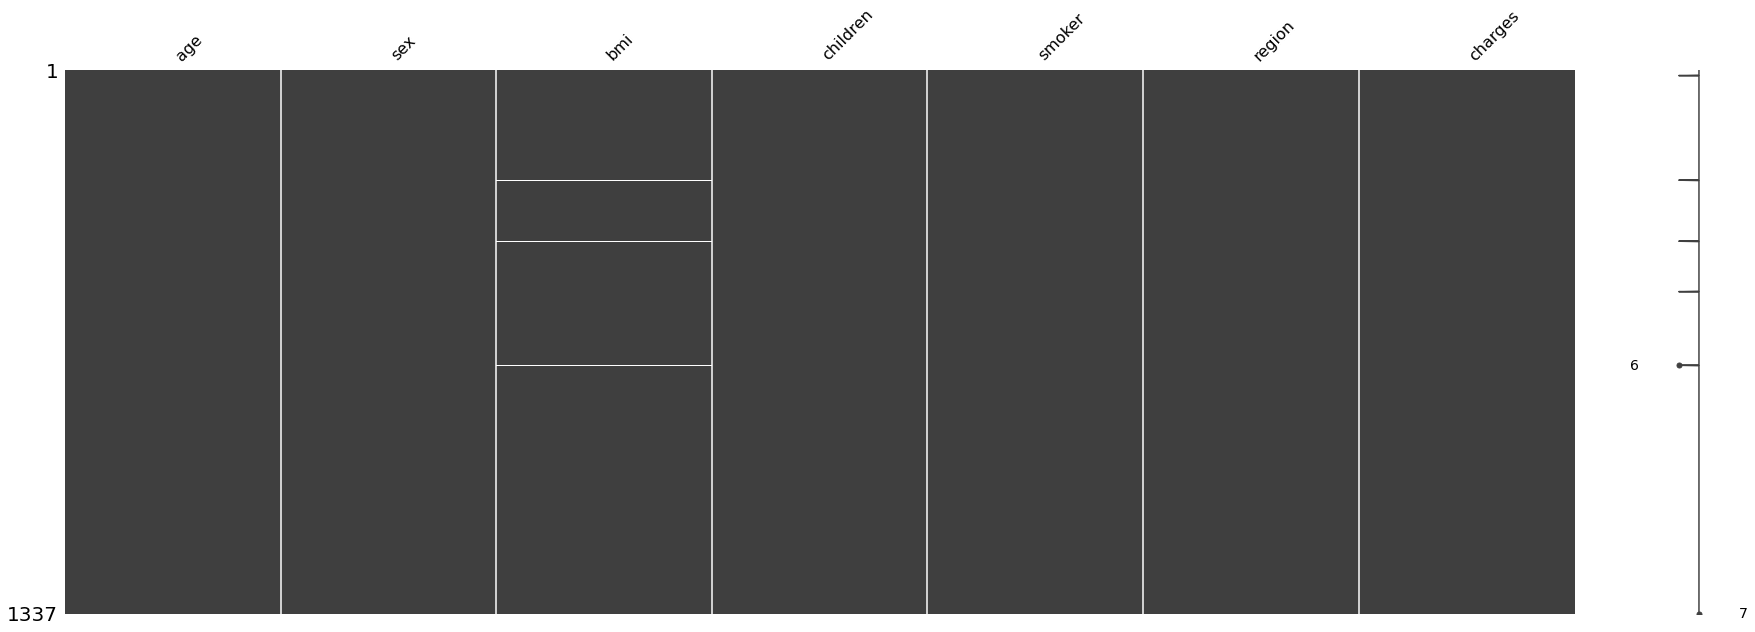

In [13]:
# 결측치 시각화

missingno.matrix(df, figsize=(30,10))
plt.show()

In [14]:
# 결측 행 확인

df.loc[data.bmi.isna()]

,age,sex,bmi,children,smoker,region,charges
14,27,male,NaN,0,yes,southeast,39611.75770
271,50,male,NaN,2,yes,southwest,42856.83800
421,61,male,NaN,0,yes,southeast,46599.10840
545,49,male,NaN,2,yes,northwest,23807.24060
727,29,female,NaN,1,yes,northeast,16657.71745


In [15]:
# 성별 별 평균 값으로 bmi 결측치 채우기

# 성별 별 평균

bmi_mean = df.groupby('sex').bmi.mean()
bmi_mean

sex
female    30.390794
male      30.922407
Name: bmi, dtype: float64

In [16]:
bmi_mean[0], bmi_mean[1]

(30.390794251134643, 30.922406855439643)

In [17]:
df.loc[(df['sex']=='male') & (df['bmi'].isna())]=df.loc[(df['sex']=='male') & (df['bmi'].isna())].fillna(bmi_mean[1])

In [18]:
df.loc[(df['sex']=='female') & (df['bmi'].isna())]=df.loc[(df['sex']=='female') & (df['bmi'].isna())].fillna(bmi_mean[1])

In [19]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [20]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


#### 4. 데이터 시각화 
- bmi와 보험금 관계(scatter)
- 흡연 여부와 보험금 관계(막대 그래프)
- 나이와 성별과 보험금 관계(막대 그래프)


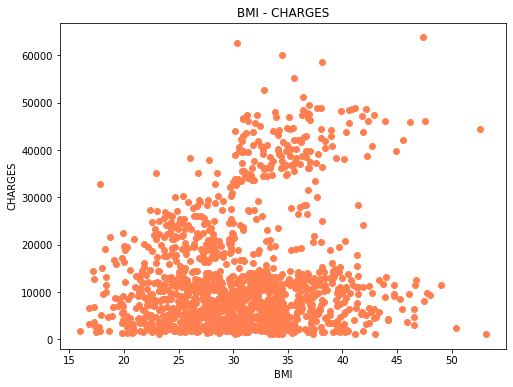

In [21]:
# bmi와 보험금 관계(성별)

plt.figure(figsize=(8,6))
plt.scatter(df['bmi'], df['charges'], color = 'coral')
plt.title('BMI - CHARGES')
plt.xlabel('BMI')
plt.ylabel('CHARGES')
plt.show()

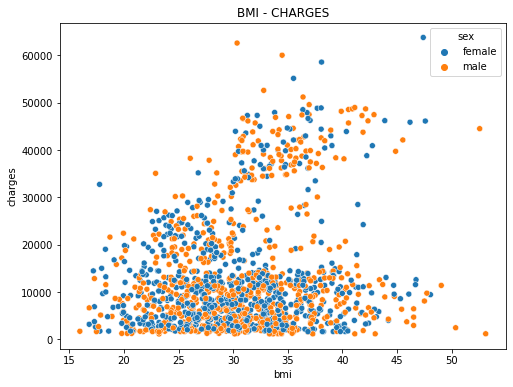

In [22]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df,x='bmi', y='charges',hue='sex')
plt.title('BMI - CHARGES')
plt.show()

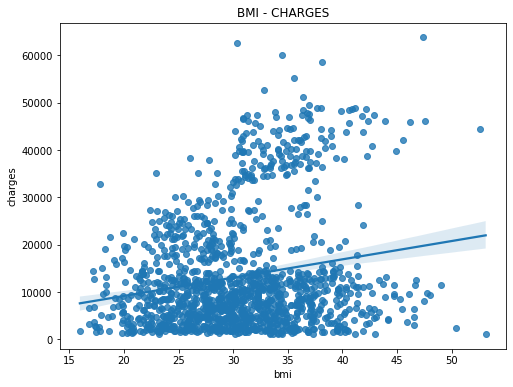

In [23]:
plt.figure(figsize=(8,6))
sns.regplot(data=df,x='bmi', y='charges')
plt.title('BMI - CHARGES')
plt.show()

In [24]:
# 흡연 여부에 따른 보험금 

smoke_char = df.groupby('smoker').charges.mean()
smoke_char

smoker
no      8440.660307
yes    32050.231832
Name: charges, dtype: float64

In [25]:
print('no smoker charges mean :',round(smoke_char[0]))
print('smoker num charges mean :',round(smoke_char[1]))


no smoker charges mean : 8441
smoker num charges mean : 32050


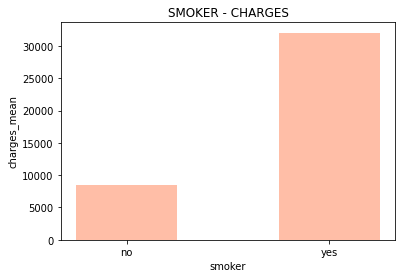

In [26]:
plt.bar(smoke_char.index, smoke_char.values, color='coral', alpha=0.5
        , width=0.5)
plt.xlabel('smoker')
plt.ylabel('charges_mean')
plt.title('SMOKER - CHARGES')
plt.show()

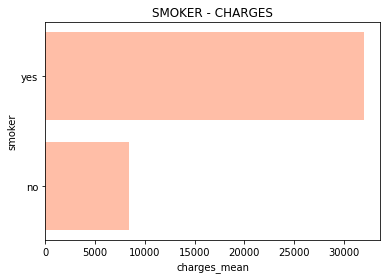

In [27]:
plt.barh(smoke_char.index, smoke_char.values, color='coral', alpha=0.5)
plt.ylabel('smoker')
plt.xlabel('charges_mean')
plt.title('SMOKER - CHARGES')
plt.show()

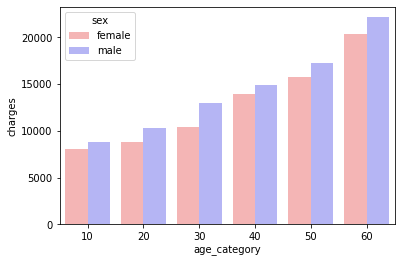

In [28]:
# 나이와 성별과 보험금 관계

def age_categorize(age):
  age = (age // 10) * 10
  return age

df['age_category'] = age_categorize(df.age)

sns.barplot(data=df, x= 'age_category', y = 'charges', palette='bwr_r',ci=False, hue='sex')

In [29]:
df.head()

,age,sex,bmi,children,smoker,region,charges,age_category
0,19,female,27.900,0,yes,southwest,16884.92400,10
1,18,male,33.770,1,no,southeast,1725.55230,10
2,28,male,33.000,3,no,southeast,4449.46200,20
3,33,male,22.705,0,no,northwest,21984.47061,30
4,32,male,28.880,0,no,northwest,3866.85520,30


#### 5. 데이터 인코딩
- sex -> female : 0, male : 1
- region -> one-hot 인코딩
- smoker -> yes : 1, no : 0


In [30]:
df['sex']=df['sex'].map({'female':0, 'male':1})
df['smoker']=df['smoker'].map({'yes':1,'no':0})

In [31]:
df.head()

,age,sex,bmi,children,smoker,region,charges,age_category
0,19,0,27.900,0,1,southwest,16884.92400,10
1,18,1,33.770,1,0,southeast,1725.55230,10
2,28,1,33.000,3,0,southeast,4449.46200,20
3,33,1,22.705,0,0,northwest,21984.47061,30
4,32,1,28.880,0,0,northwest,3866.85520,30


In [32]:
one_hot = pd.get_dummies(df['region'])
one_hot

,northeast,northwest,southeast,southwest
0,0,0,0,1
1,0,0,1,0
2,0,0,1,0
3,0,1,0,0
4,0,1,0,0
...,...,...,...,...
1333,0,1,0,0
1334,1,0,0,0
1335,0,0,1,0
1336,0,0,0,1


In [33]:
df = pd.concat([df, one_hot], axis=1)

In [34]:
df = df.drop(['region'], axis=1)

In [35]:
df = df.drop(['age_category'],axis=1)

In [36]:
df.head()

,age,sex,bmi,children,smoker,charges,northeast,northwest,southeast,southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


### 모델링
1. 데이터 스케일링
2. 데이터 분리
3. 학습 및 평가

#### 1) 데이터 스케일링

In [37]:
ss = StandardScaler()
df[['age','bmi']] = ss.fit_transform(df[['age','bmi']])
df.head()

,age,sex,bmi,children,smoker,charges,northeast,northwest,southeast,southwest
0,-1.440418,0,-0.453774,0,1,16884.92400,0,0,0,1
1,-1.511647,1,0.511464,1,0,1725.55230,0,0,1,0
2,-0.799350,1,0.384848,3,0,4449.46200,0,0,1,0
3,-0.443201,1,-1.308018,0,0,21984.47061,0,1,0,0
4,-0.514431,1,-0.292627,0,0,3866.85520,0,1,0,0


#### 2) 데이터 분리

In [38]:
y = df['charges']

In [39]:
df = df.drop(['charges'], axis=1)

In [40]:
X = df

In [41]:
type(X)

pandas.core.frame.DataFrame

In [42]:
type(y)

pandas.core.series.Series

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=2022)

In [44]:
X_train.shape, X_test.shape

((1069, 9), (268, 9))

#### 3) 모델 학습 및 평가
> 사용 모델 
- LinearRegression 
- SVR
- DecisionTreeRegressor
- RandomForestRegressor 


In [53]:
# LinearRegression

# fit model
lr = LinearRegression().fit(X_train,y_train)

# predict
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Score 확인
print("lr.coef_: {}".format(lr.coef_))
print("lr.intercept_: {}".format(lr.intercept_))
print('lr train score %.3f, lr test score: %.3f' % (
lr.score(X_train,y_train),
lr.score(X_test, y_test)))

lr.coef_: [ 3407.64540294  -392.09536144  2070.2571403    396.26726499
 23435.57322251   658.58660373   311.51579734  -568.45196144
  -401.65043963]
lr.intercept_: 8292.212397993415
lr train score 0.731, lr test score: 0.810


In [55]:
# SVR

# fit model
svr = SVR(kernel='linear', C = 300)
svr = svr.fit(X_train,y_train.values.ravel())

# predict
y_train_pred = svr.predict(X_train)
y_test_pred = svr.predict(X_test)

# Score 확인
print('svr train score %.3f, svr test score: %.3f' % (
svr.score(X_train,y_train),
svr.score(X_test, y_test)))

svr train score 0.575, svr test score: 0.634


In [56]:
# 랜덤 포레스트

forest = RandomForestRegressor(n_estimators = 100,
                              criterion = 'mse',
                              random_state = 1,
                              n_jobs = -1)

# fit model
forest.fit(X_train,y_train.values.ravel())
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

# Score 확인
print('forest train score %.3f, forest test score: %.3f' % (
forest.score(X_train, y_train),
forest.score(X_test, y_test)))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


forest train score 0.973, forest test score: 0.886


In [57]:
# 결정 나무

dt = DecisionTreeRegressor(random_state=0)

# fit model
dt = dt.fit(X_train,y_train.values.ravel())
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

# Score 확인
print('dt train score %.3f, dt test score: %.3f' % (
dt.score(X_train,y_train),
dt.score(X_test, y_test)))

dt train score 0.998, dt test score: 0.747


In [58]:
# 앞에서 만든 regressor 변수들과 라벨을 묶어서 하나의 리스트로 모으기
regressors = [(lr, 'Linear Regression'),
                (svr, 'SupportVector Regression'),
                (forest, 'RandomForest Regression'),
                (dt, 'DecisionTree')]

# 각 regressor 변수들과 라벨 묶음을 차례로 fit -> predict -> score 로 처리해서 보여주기
for reg, label in regressors:
    print(80*'_', '\n')
    reg = reg.fit(X_train,y_train.values.ravel())
    y_train_pred = reg.predict(X_train)
    y_test_pred = reg.predict(X_test)
    print(f'{label} train score %.3f, {label} test score: %.3f' % (
    reg.score(X_train,y_train),
    reg.score(X_test, y_test)))

________________________________________________________________________________ 

Linear Regression train score 0.731, Linear Regression test score: 0.810
________________________________________________________________________________ 

SupportVector Regression train score 0.575, SupportVector Regression test score: 0.634
________________________________________________________________________________ 



/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


RandomForest Regression train score 0.973, RandomForest Regression test score: 0.886
________________________________________________________________________________ 

DecisionTree train score 0.998, DecisionTree test score: 0.747
